In [9]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score, classification_report, zero_one_loss
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.linear_model import SGDClassifier  # For decision boundary visualization
from sklearn.linear_model import LogisticRegression  # For main logistic regression models
from sklearn.multioutput import MultiOutputClassifier

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Plot configuration
plot_kwargs = {'cmap': 'jet',     # color scheme for decision boundary
               'response_method': 'predict',
               'plot_method': 'pcolormesh',
               'shading': 'auto',
               'alpha': 0.5,
               'grid_resolution': 100}

# Set random seed for reproducibility
seed = 1234
np.random.seed(seed)

In [14]:
# Load the training data
train = pd.read_csv("train.csv")

# Extract the comment text (features) and labels (targets)
X = train['comment_text'].fillna('')  # Replace missing values with an empty string
y = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]  # Six labels (0s and 1s)

# Text Vectorization
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=seed)

# Standardize the features for visualization and better model performance
scaler = StandardScaler(with_mean=False)  # TF-IDF is sparse, so `with_mean=False` avoids errors
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Logistic Regression Model for each label
multi_log_reg = MultiOutputClassifier(
    LogisticRegression(max_iter=200, C=1, penalty='l2', class_weight='balanced')
)
multi_log_reg.fit(X_train_scaled, y_train)


MultiOutputClassifier(estimator=LogisticRegression(C=1, class_weight='balanced',
                                                   max_iter=200))


ROC-AUC Scores for Each Label:

ROC-AUC for toxic: 0.9263
ROC-AUC for severe_toxic: 0.8879
ROC-AUC for obscene: 0.9263
ROC-AUC for threat: 0.9073
ROC-AUC for insult: 0.9127
ROC-AUC for identity_hate: 0.8544

Classification Report (for each label):

               precision    recall  f1-score   support

        toxic       0.56      0.78      0.65      3002
 severe_toxic       0.14      0.46      0.21       297
      obscene       0.50      0.76      0.60      1612
       threat       0.23      0.40      0.29        91
       insult       0.41      0.69      0.51      1495
identity_hate       0.12      0.42      0.18       277

    micro avg       0.43      0.72      0.54      6774
    macro avg       0.32      0.58      0.41      6774
 weighted avg       0.47      0.72      0.56      6774
  samples avg       0.06      0.07      0.06      6774



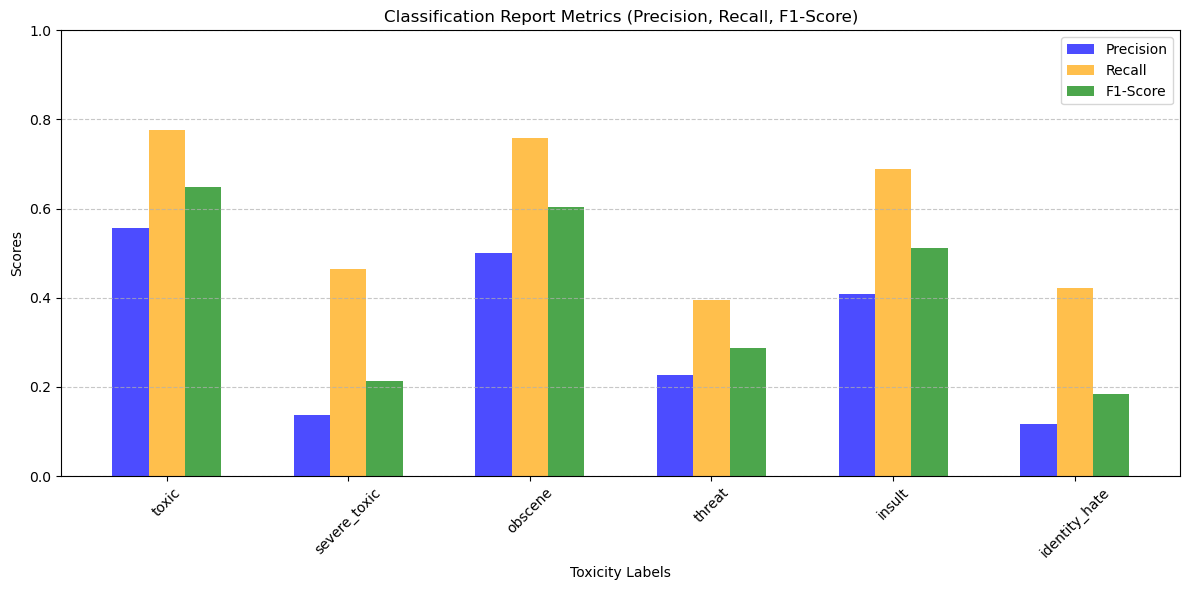

In [16]:
from sklearn.metrics import roc_auc_score, classification_report

# Evaluate the model on the test set
y_pred = multi_log_reg.predict(X_test_scaled)  # Get binary predictions (0 or 1) for each label
y_proba = np.array([proba[:, 1] for proba in multi_log_reg.predict_proba(X_test_scaled)]).T  # Get probability of "toxic" (1) for each label

# Calculate ROC-AUC score for each label
roc_auc_scores = [roc_auc_score(y_test.iloc[:, i], y_proba[:, i]) for i in range(len(y.columns))]

# Print ROC-AUC for each label
print("\nROC-AUC Scores for Each Label:\n")
for i, label in enumerate(y.columns):
    print(f'ROC-AUC for {label}: {roc_auc_scores[i]:.4f}')

# Print classification report
print("\nClassification Report (for each label):\n")
print(classification_report(y_test, y_pred, target_names=y.columns, zero_division=0))

report = classification_report(y_test, y_pred, target_names=y.columns, output_dict=True, zero_division=0)

# Extract precision, recall, and F1-scores for each label
labels = y.columns
precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1_score = [report[label]['f1-score'] for label in labels]

# Plot the data as a grouped bar chart
x = np.arange(len(labels))  # Label indices
width = 0.2  # Width of each bar

plt.figure(figsize=(12, 6))
plt.bar(x - width, precision, width, label='Precision', color='blue', alpha=0.7)
plt.bar(x, recall, width, label='Recall', color='orange', alpha=0.7)
plt.bar(x + width, f1_score, width, label='F1-Score', color='green', alpha=0.7)

# Add labels, title, and legend
plt.xlabel('Toxicity Labels')
plt.ylabel('Scores')
plt.title('Classification Report Metrics (Precision, Recall, F1-Score)')
plt.xticks(x, labels, rotation=45)
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


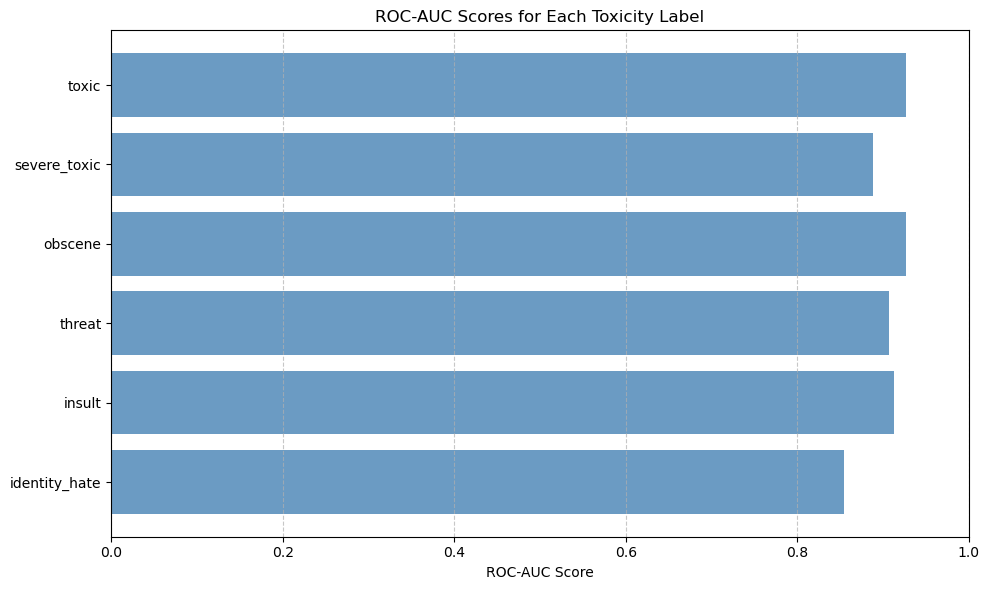

In [19]:
# Plot the bar chart for ROC-AUC scores
plt.figure(figsize=(10, 6))
plt.barh(labels, roc_auc_scores, color='steelblue', alpha=0.8)

# Add labels, title, and formatting
plt.xlabel('ROC-AUC Score')
plt.title('ROC-AUC Scores for Each Toxicity Label')
plt.xlim(0, 1)  # ROC-AUC scores range from 0 to 1
plt.gca().invert_yaxis()  # Put the most important label at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

Add Precision-Recall AUC:

In [20]:
from sklearn.metrics import precision_recall_curve, auc

# Ensure y_proba is in the correct shape (num_samples, num_labels)
# If y_proba is a list of arrays, convert it to a 2D array
y_proba_array = np.array([proba[:, 1] for proba in multi_log_reg.predict_proba(X_test_scaled)]).T

# Loop over each label to calculate precision-recall AUC
for i, label in enumerate(y.columns):
    precision, recall, _ = precision_recall_curve(y_test.iloc[:, i], y_proba_array[:, i])
    pr_auc = auc(recall, precision)
    print(f'PR-AUC for {label}: {pr_auc:.4f}')


PR-AUC for toxic: 0.7829
PR-AUC for severe_toxic: 0.0996
PR-AUC for obscene: 0.7362
PR-AUC for threat: 0.2232
PR-AUC for insult: 0.5663
PR-AUC for identity_hate: 0.0910


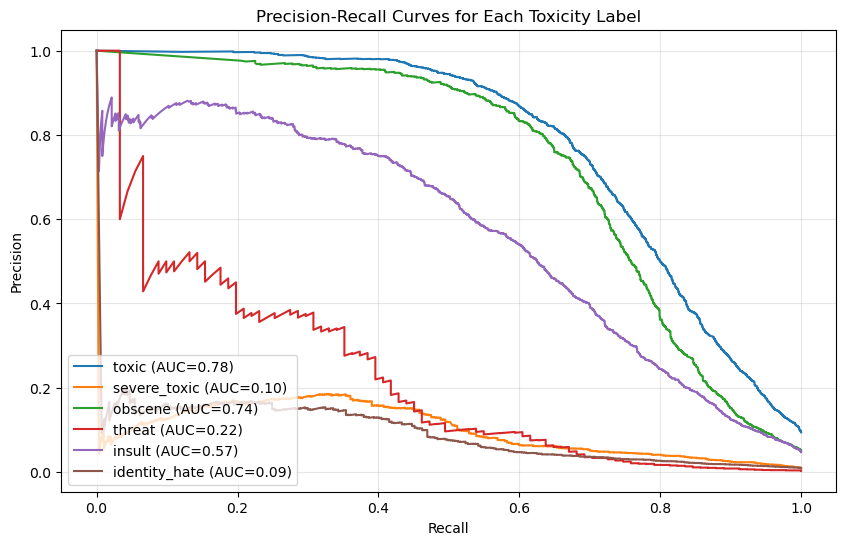

In [23]:
# Ensure y_proba is in the correct shape (num_samples, num_labels)
# If y_proba is a list of arrays, convert it to a 2D array
y_proba_array = np.array([proba[:, 1] for proba in multi_log_reg.predict_proba(X_test_scaled)]).T

# Plot precision-recall curves for each label
plt.figure(figsize=(10, 6))

# Loop over each label to calculate and plot precision-recall curve
for i, label in enumerate(y.columns):
    precision, recall, _ = precision_recall_curve(y_test.iloc[:, i], y_proba_array[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{label} (AUC={pr_auc:.2f})')

# Plot formatting
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Toxicity Label')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.show()

ROC curve for each label to visualize how well the model separates classes:

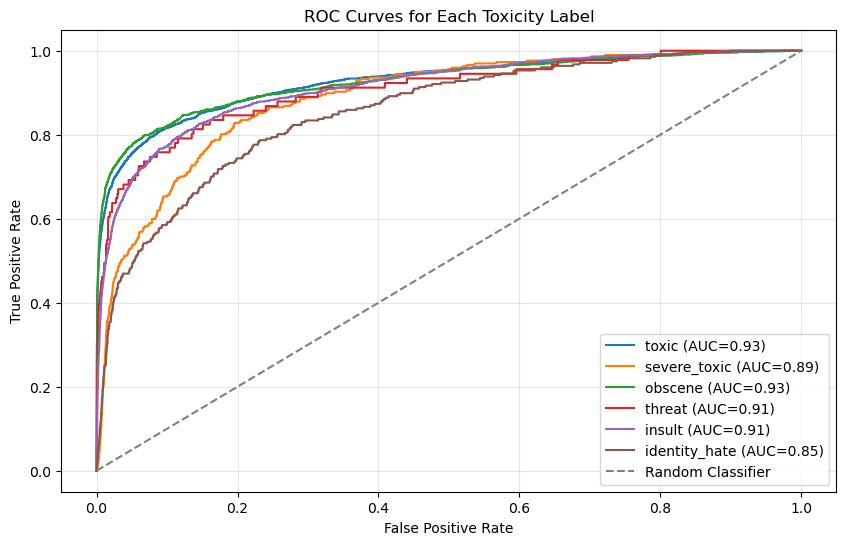

In [22]:
from sklearn.metrics import roc_curve

# Ensure y_proba is in the correct shape (num_samples, num_labels)
y_proba_array = np.array([proba[:, 1] for proba in multi_log_reg.predict_proba(X_test_scaled)]).T

# Plot ROC curve for each label
plt.figure(figsize=(10, 6))
for i, label in enumerate(y.columns):
    fpr, tpr, _ = roc_curve(y_test.iloc[:, i], y_proba_array[:, i])
    plt.plot(fpr, tpr, label=f'{label} (AUC={roc_auc_scores[i]:.2f})')

# Add diagonal line for random guessing (no-skill classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

# Plot formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Toxicity Label')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()
